# <p style="padding: 20px; font-family: 'JetBrains Mono'; font-weight: bold; font-size: 100%; color: #2F486B; letter-spacing: 2px; text-align: center; border-radius: 4px; border: 1px solid #2F486B; background-color: #FCFCFC">ML Explainability - Shapley Values &amp; SHAP</p>
<figure>
    <center><img src="https://raw.githubusercontent.com/mateuszk098/kaggle_notebooks/master/shap_shapley_values/analysis.png" width=600px>
    </center>
</figure>

In [63]:
# %load ../general_settings.py
import os
import shutil
import subprocess
import warnings
from collections import defaultdict, namedtuple
from copy import copy
from functools import partial
from itertools import chain, combinations, product
from pathlib import Path
from time import strftime

ON_KAGGLE = os.getenv("KAGGLE_KERNEL_RUN_TYPE") is not None
if ON_KAGGLE:
    warnings.filterwarnings("ignore")

import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import scipy.stats as stats
import seaborn as sns
import shap
from colorama import Fore, Style
from IPython.core.display import HTML, display_html
from plotly.subplots import make_subplots
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform

from shap import explainers, maskers
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

# Colorama settings.
CLR = (Style.BRIGHT + Fore.BLACK) if ON_KAGGLE else (Style.BRIGHT + Fore.WHITE)
RED = Style.BRIGHT + Fore.RED
BLUE = Style.BRIGHT + Fore.BLUE
CYAN = Style.BRIGHT + Fore.CYAN
RESET = Style.RESET_ALL

FONT_COLOR = "#2F486B"
BACKGROUND_COLOR = "#FFFCFA"

CELL_HOVER = {  # for row hover use <tr> instead of <td>
    "selector": "td:hover",
    "props": "background-color: #FCFCFC",
}
TEXT_HIGHLIGHT = {
    "selector": "td",
    "props": "color: #3E3F4C; font-weight: bold",
}
INDEX_NAMES = {
    "selector": ".index_name",
    "props": "font-style: italic; background-color: #2F486B; color: #FCFCFC;",
}
HEADERS = {
    "selector": "th:not(.index_name)",
    "props": "font-style: italic; background-color: #2F486B; color: #FCFCFC;",
}
DF_STYLE = (INDEX_NAMES, HEADERS, TEXT_HIGHLIGHT)
DF_CMAP = sns.light_palette("#D4D0A9", as_cmap=True)

# Utility functions.
def download_dataset_from_kaggle(user, dataset, directory):
    command = "kaggle datasets download -d "
    filepath = directory / (dataset + ".zip")
    if not filepath.is_file():
        subprocess.run((command + user + "/" + dataset).split())
        filepath.parent.mkdir(parents=True, exist_ok=True)
        shutil.unpack_archive(dataset + ".zip", "data")
        shutil.move(dataset + ".zip", "data")


def download_competition_from_kaggle(competition):
    command = "kaggle competitions download -c "
    filepath = Path("data/" + competition + ".zip")
    if not filepath.is_file():
        subprocess.run((command + competition).split())
        Path("data").mkdir(parents=True, exist_ok=True)
        shutil.unpack_archive(competition + ".zip", "data")
        shutil.move(competition + ".zip", "data")


def interpolate_color(color1, color2, t):
    r1, g1, b1 = int(color1[1:3], 16), int(color1[3:5], 16), int(color1[5:7], 16)
    r2, g2, b2 = int(color2[1:3], 16), int(color2[3:5], 16), int(color2[5:7], 16)
    r = int(r1 + (r2 - r1) * t)
    g = int(g1 + (g2 - g1) * t)
    b = int(b1 + (b2 - b1) * t)
    return f"#{r:02X}{g:02X}{b:02X}"


def get_interpolated_colors(color1, color2, num_colors=2):
    """Return `num_colors` interpolated beetwen `color1` and `color2`.
    Arguments need to be HEX."""
    num_colors = num_colors + 2
    return [interpolate_color(color1, color2, i / (num_colors - 1)) for i in range(num_colors)]


# Html `code` block highlight. Must be included at the end of all imports!
HTML(
    """
<style>
code {
    background: rgba(123, 171, 237, 0.25) !important;
    border-radius: 4px !important;
    color: rgba(47, 72, 107, 1.0) !important;
}
</style>
"""
)


<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color: #FCFCFC;
    padding: 20px;
    border-radius: 4px;
    border: 1px solid #2F486B;
">
<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    border-bottom: 1px solid #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>Notebook Description</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    This notebook aims to present machine learning models' interpretability and explainability using the so-called <b>Shapley values</b> and <code>shap</code> library. The <code>shap</code> library will be depicted in both regression and classification problems. We will use some easy datasets like as <b>Titanic</b> and <b>House Prices</b>. 
</p>

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    border-bottom: 1px solid #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>This Notebook Covers</b> 📔
</p>

<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    <li>Explanation of Shapley values in machine learning.</li>
    <li>Interpretability of features influence within SHAP.</li>
    <li>The answer to the question of why the model taken up such and not another decision.</li>
</ul>

</blockquote>

# <p style="padding: 20px; font-family: 'JetBrains Mono'; font-weight: bold; font-size: 100%; color: #2F486B; letter-spacing: 2px; text-align: center; border-radius: 4px; border: 1px solid #2F486B; background-color: #FCFCFC">Shapley Values</p>

<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color: #FCFCFC;
    padding: 20px;
    border-radius: 4px;
    border: 1px solid #2F486B;
">
<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    border-bottom: 1px solid #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>Can you explain why your model predicts such and not another value?</b> 🤔
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    Can you answer this question? If not, <b>SHAP (SHapley Additive exPlanations)</b> is something for you. I found out about <b>SHAP</b> maybe a week before this notebook was published. I noticed that in several notebooks but without any explanations. Therefore, I was just curious about what is that library and how to utilise it to better understand my models.
</p>
    
<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    border-bottom: 1px solid #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>Shapley Values Introduction</b> 💡
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    Let's get started from the beginning. Generally, <b>SHAP</b> is a specific approach that helps you understand and explain your model's individual predictions. That method is based on <b>Shapley's values</b> from cooperative game theory. The point is that, we can consider prediction process as a game where certain features are players and prediction is a gain. <b>SHAP</b> tells us how to distribute the contribution of each feature into certain prediction fairly. So, what exactly is a Shapley value? Well, it's an <b>average marginal contribution of a feature value across all possible coalitions of features.</b> Understandable? Of course, not. Let me explain this step by step.<br>
    Let's suppose we need to build a machine learning model which has to predict house prices considering different attributes like median house age or number of rooms. Assume we have only four features to make it as easy as possible. These are the <code>HouseAge</code> (median house age in block group), <code>AveRooms</code> (average number of rooms per household), <code>AveOccup</code> (average number of household members), and <code>Population</code> (block group population). These features are a subset of the <b>California Housing</b> dataset from <code>scikit-learn</code>, which we will use later. Okay, so we've just built such a model, and it turns out that the average house price for samples in the training dataset is $200,000$. After that, we test it on a test dataset. We take a new sample and must predict its price. We get $250,000$, and somebody could ask us why there is such a difference? <b>More precisely, how much each feature of this certain observation contributes to the prediction compared to the average price?</b><br>
    In the case of linear models, the answer is easy, i.e. the prediction is just the sum of the weight of each feature times the feature value plus intercept. Weights and intercept are found by minimizing the cost function. Nevertheless, in the case of boosted trees or neural networks, the answer is a challenge. For such cases, the problem of model explainability is solved by a method from cooperative game theory - this is the place where <b>SHAP</b> comes into play. It explains the difference between specific prediction and average prediction (made for the whole dataset, for example, the training one).
</p>

<figure>
    <center>
        <img src="https://raw.githubusercontent.com/mateuszk098/kaggle_notebooks/master/shap_shapley_values/example.png" width=600px>     
    <center>
    <figcaption>
        <p style="font-size: 16px; font-family: 'JetBrains Mono'; color: #2F486B; margin-left: 50px; margin-right: 50px"><b>Figure:</b> The average house price for the training dataset is $200,000$, but for the new observation, it's $250,000$. The explanation may be something like that: house age ($80$) contributes $+20,000$, rooms (five) contribute $+40,000$, and population (six) contributes $-10,000$. In total, these features contribute $+50,000$ to the average price.</p>.
    </figcaption>
    </center>
</figure>

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    border-bottom: 1px solid #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>How to calculate Shapley value?</b> 🕵
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    Calculation of Shapley value for a specific feature is based on coalitions of features. Let's get back to the example with house prices, and suppose we want to calculate the Shapley value for a <code>HouseAge</code> feature for a specific sample (Shapley value is associated with a specific sample and specific feature). Firstly, consider the coalition of <code>AveRooms</code> and <code>Population</code>. As we want to assess the contribution of <code>HouseAge</code> (for example $30$ for this observation), we take values of these three features for that sample and randomly pick some value for the <code>AveOccup</code> from another sample. We evaluate the model and get a prediction of $220,000$. After that, we remove <code>HouseAge</code> from the coalition by picking the value for that feature from the sample drawn earlier (let's say <code>HouseAge</code> is $40$ there). We re-evaluate the model and get $200,000$. The contribution of <code>HouseAge</code> component is +$20,000$ in this case. <b>These calculations depend on randomly drawn samples, and we should perform many test iterations to get a more reliable result. Moreover, we repeat this calculation for all possible coalitions of features.</b> These coalitions are:
<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    <li>No coalition of features.</li>
    <li><code>AveRooms</code>.</li>
    <li><code>AveOccup</code>.</li>
    <li><code>Population</code>.</li>
    <li><code>AveRooms</code>, <code>AveOccup</code>.</li>
    <li><code>AveRooms</code>, <code>Population</code>.</li>
    <li><code>AveOccup</code>, <code>Population</code>.</li>
    <li><code>AveRooms</code>, <code>AveOccup</code>, <code>Population</code>.</li>
</ul>
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    For all of these coalitions, we compute the predicted price, with and without feature <code>HouseAge</code> value and take marginal contribution as the difference between prices. Let me illustrate this with example of <b>California Housing</b> dataset. California Housing dataset accounts for a very simple regression problem, which can be used as a background in different examples we want to talk about. It consists of eight attributes, and the target variable is the median house value for California districts, expressed in hundreds of thousands of dollars. For the purposes of this notebook, we will take only four features and build a simple linear regression model.
</p>

</blockquote>

In [64]:
X, y = fetch_california_housing(return_X_y=True, as_frame=True)

# Let's take only four features.
features = ["HouseAge", "AveRooms", "Population", "AveOccup"]

X_train, X_valid, y_train, y_valid = train_test_split(
    X[features], y, test_size=0.1, random_state=42
)

scaler = StandardScaler().set_output(transform="pandas")
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

model = LinearRegression().fit(X_train, y_train)


<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color: #FCFCFC;
    padding: 20px;
    border-radius: 4px;
    border: 1px solid #2F486B;
">
<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    border-bottom: 1px solid #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>What we exactly want to do?</b> 🤔
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    We want to calculate the Shapley value for a specific sample from the validation dataset by hand and then compare it to the Shapley value obtained from <code>shap</code> library. In this case, we want to explain contribution of <code>HouseAge</code> (which is the first feature - $0$). Therefore, we fetch an example dataset and take only four features (just for ease of use). Then we split this dataset into training and validation ones and fit the ordinary linear model. After that, we define a sample number from the validation dataset and a number of the feature. <b>For this certain sample and feature, we want to calculate the Shapley value. To do that, we need to create all coalitions of features without that certain one, we examine.</b> In this example, features are presented as integer numbers, i.e. <code>HouseAge</code> feature is the first, so it has a number $0$.
</p>
</blockquote>

In [65]:
sample_no = 0  # Number of sample from valid dataset.
feature_no = 0  # Number of feature, that contribution we want to explain.
n_features = len(X_train.columns)

feature_ids = list(range(n_features))
feature_ids.remove(feature_no)

nested_combs = list(list(combinations(feature_ids, r)) for r in range(0, n_features))
features_combs = np.array(list(chain(*nested_combs)), dtype=object)
all_features = np.arange(n_features)

print(CLR + "All possible coalitions of features (without `HouseAge`)")
print(RED + "=>", *features_combs)


All possible coalitions of features (without `HouseAge`)
=> () (1,) (2,) (3,) (1, 2) (1, 3) (2, 3) (1, 2, 3)


<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color: #FCFCFC;
    padding: 20px;
    border-radius: 4px;
    border: 1px solid #2F486B;
">
<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    border-bottom: 1px solid #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>Monte Carlo estimation of Shapley value</b> 📔
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    In the case of a large number of features, the calculation for all coalitions is complex (probably not possible?). However, there is an approximate method for that, based on <b>Monte-Carlo sampling</b>. This method calculates Shapley value for certain feature $j$ and certain sample $x$:
    \[\hat{\phi}_j(x) = \frac{1}{N}\sum_{n=1}^N \left[\hat{f}(x_{+j}^n) - \hat{f}(x_{-j}^n)\right],\] where $N$ is the number of sampling steps, $\hat{f}(x_{+j}^n)$ is the prediction for sample $x$ in the step $n$, where the part of feature values from this sample has been replaced by values from randomly picked observation, but value of feature $j$ still comes from $x$. The second part: $\hat{f}(x_{-j}^n)$, is similar to the first one but value of feature $j$ is replaced by value from that randomly chosen observation. Pseudo algorithm that calculates Shapley value is described below:
    <b>
    <ol style="
        font-size: 16px;
        font-family: 'JetBrains Mono';
        color: #2F486B;
        margin-left: 15px;
        margin-right: 15px;
    ">
        <li>Choose a specific observation $x$, a specific feature $j$, and a number of sampling steps $N$.</li>
        <li>For each $n$ in $N$:</li>
        <ol style="
            font-size: 16px;
            font-family: 'JetBrains Mono';
            color: #2F486B;
            margin-left: 15px;
            margin-right: 15px;
        ">
            <li>Draw a random sample $z$ and a random subset of features (coalitions).</li>
            <li>Create a new sample $v$, where values of features coalition are taken from $x$, and the rest values of features are taken from $z$.</li>
            <li>Create two new samples $v_p$ and $v_m$ by copying $v$. In the sample $v_p$, replace the value of feature $j$ with a value of that feature from sample $x$, and in $v_m$ replace the value of feature $j$ with a value of that feature from sample $z$.</li>
            <li>Calculate a marginal contribution: $model(v_p)$ - $model(v_m)$, and store it.</li>
        </ol>
        <li>Average all marginal contributions by dividing by $N$. You've just obtained the approximate Shapley value for sample $x$ and feature $j$.</li>
    </ol>
    </b>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    In our case, we have only four features, so all combinations are calculable in a short time, so we perform something between Monte-Carlo sampling and direct calculation. See the cell below.
</p>
</blockquote>

In [66]:
np.random.seed(42)

n_iterations = 1000
marginal_contributions = np.zeros(n_iterations, dtype=np.float32)

for i in range(n_iterations):
    random_no = np.random.randint(len(X_train))

    x_features = np.array(np.random.choice(features_combs))  # Coalitions
    z_features = np.setdiff1d(all_features, x_features)  # Feature values from random observation.

    x = X_valid.iloc[sample_no, x_features]  # Sample we examine.
    z = X_train.iloc[random_no, z_features]  # Random sample, which serves as a donor.

    v = pd.DataFrame({**x.to_dict(), **z.to_dict()}, index=[0])[X_valid.columns]

    v_p = v.copy()  # Sample with original value of feature `j`.
    v_m = v.copy()  # Sample with replaced value of feature `j`.

    v_p.iloc[:, feature_no] = X_valid.iloc[sample_no, feature_no]
    v_m.iloc[:, feature_no] = X_train.iloc[random_no, feature_no]

    marginal_contributions[i] = model.predict(v_p) - model.predict(v_m)

print(CLR + "Shapley value by hand:", RED + f"{marginal_contributions.mean():.5f}")


Shapley value by hand: -0.04785


<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color: #FCFCFC;
    padding: 20px;
    border-radius: 4px;
    border: 1px solid #2F486B;
">
<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    border-bottom: 1px solid #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>Notes</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    Okay, we've got some value, but does it have any sense? We need to compare it with the output from the <code>shap</code> library. In the bottom cell, we define a new <b>linear explainer</b> (as we used a linear model for training). We pass there the model and something like the <code>shap</code> library calls a masker, that is used to <i>train</i> the explainer.
</p>
</blockquote>

In [67]:
masker = maskers.Independent(X_train, max_samples=len(X_train))
explainer = explainers.Linear(model, masker)
shap_values = explainer(X_valid.iloc[[sample_no], :])

print(CLR + "SHAP Output:\n")
print(shap_values, "\n")
print(CLR + "Shapley value from SHAP library:", RED + f"{shap_values.values[0, feature_no]:.5f}")


SHAP Output:

.values =
array([[-0.04669537, -0.09805405, -0.00112126, -0.00220943]])

.base_values =
array([2.06861739])

.data =
array([[-0.28671279, -0.49353058, -0.03075389,  0.0726769 ]]) 

Shapley value from SHAP library: -0.04670


<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color: #FCFCFC;
    padding: 20px;
    border-radius: 4px;
    border: 1px solid #2F486B;
">
<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    border-bottom: 1px solid #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>Observations</b> 📔
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    Using <code>shap</code> library, the Shapley value is hidden in the <code>values</code> attribute of the explainer. We analyse the first feature, so it's the first value of that array. The remaining attributes are: <code>base_values</code>, which means the average prediction for the given dataset (the training dataset passed to the masker), and <code>data</code>, which is exactly the array of our examined sample. <b>As you can see, perhaps the result calculated by hand is not a world champion, but these results are comparable. I checked several different configurations, and these values follow each other.</b><br>
</p>

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    border-bottom: 1px solid #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>Shapley value properties</b> 💡
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    Shapley value interpretation may be confusing. <b>The interpretation is that the value of feature $j$ contributed in different coalitions by $\hat{\phi}_j(x)$ to the prediction for this specific observation, in comparison to the average prediction.</b> It's not the difference between predictions when we remove this feature from the dataset. Shapley value fulfills four axioms. These are:
<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    <li>Feature contributions must sum up to the difference of sample prediction and average prediction (see code below).</li>
    <li>If two feature values equally contribute in all coalitions, then contribution of these should be equal.</li>
    <li>The Shapley value of the feature value is equal to zero if it doesn't change anything during prediction in different coalitions.</li>
    <li>In the example of a random forest - if we calculate the Shapley value for each tree individually, average it and then calculate the Shapley value for a random forest, they are the same.</li>
</ul>
</p>
</blockquote>

In [68]:
avg_prediction = model.predict(X_train).mean()
print(CLR + "Average model prediction for training dataset:", RED + f"{avg_prediction:.5f}")


Average model prediction for training dataset: 2.06862


In [69]:
sample_prediction = model.predict(X_valid.iloc[[sample_no], :])[0]
print(CLR + "Model prediction for chosen sample:", RED + f"{sample_prediction:.5f}")


Model prediction for chosen sample: 1.92054


In [70]:
print(
    CLR + "Sum of average prediction and all Shapley values of chosen sample:",
    RED + f"{avg_prediction + shap_values.values.sum():.5f}",
)


Sum of average prediction and all Shapley values of chosen sample: 1.92054


<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color: #FCFCFC;
    padding: 20px;
    border-radius: 4px;
    border: 1px solid #2F486B;
">
<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    border-bottom: 1px solid #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>What is Shapley value?</b> 🤔
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>The Shapley value is the average marginal contribution of a feature value across all possible coalitions of features.</b><br>
    Understandable? I hope so.
</p>

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    border-bottom: 1px solid #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>Quick Summary</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    That's all that I wanted to present about Shapley's values. I hope you found out something new. For me, it's a completely new topic so I tried to pass it on best I can. I hope there are no mistakes, but if you are familiar with this you can let me know in the comments section. Then, I will try to fix if something is wrong.<br><br>
    <b>References:</b><br>
    <ul style="
        font-size: 16px;
        font-family: 'JetBrains Mono';
        color: #2F486B;
        margin-left: 15px;
        margin-right: 15px;
    ">
        <li><a href="https://arxiv.org/abs/1705.07874" style="color: #C94040;"><b>A Unified Approach to Interpreting Model Predictions</b></a></li>
        <li><a href="https://christophm.github.io/interpretable-ml-book/shapley.html" style="color: #C94040;"><b>Shapley Values</b></a></li>
        <li><a href="https://christophm.github.io/interpretable-ml-book/shap.html" style="color: #C94040;"><b>SHAP (SHapley Additive exPlanations)</b></a></li>
    </ul>
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    We already know something about the Shapley values, so we get to the library in itself. Firstly, we will focus on the regression problem and try to explain predictions from the test dataset.
</p>

</blockquote>

# <p style="padding: 20px; font-family: 'JetBrains Mono'; font-weight: bold; font-size: 100%; color: #2F486B; letter-spacing: 2px; text-align: center; border-radius: 4px; border: 1px solid #2F486B; background-color: #FCFCFC">SHAP in Regression</p>

<figure>
    <center><img src="https://raw.githubusercontent.com/mateuszk098/kaggle_notebooks/master/shap_shapley_values/shap_header.png" alt="SHAP" width=640px></center></br>
    <center><figcaption><b style="font-size: 16px; font-family: 'JetBrains Mono'; color: #2F486B">Explanation by SHAP. Source: <a href="https://shap.readthedocs.io/en/latest/" style="color: #C94040">SHAP documentation</b></a>.</figcaption></center>
</figure>


<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color: #FCFCFC;
    padding: 20px;
    border-radius: 4px;
    border: 1px solid #2F486B;
">
<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    border-bottom: 1px solid #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>Notes</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    The <code>shap</code> library is based on a game theoretic approach - Shapley values (and their extensions) to explain any machine learning model (from simple linear regression up to neural networks). In this section, we will see how <code>shap</code> handles with models' output explainability. We are starting with the regression problem. For this purpose, we're using <b>House Prices dataset</b>. Firstly, let's load that.
</p>
</blockquote>

In [71]:
competition = "house-prices-advanced-regression-techniques"

if not ON_KAGGLE:
    download_competition_from_kaggle(competition)
    train_path = "data/train.csv"
    test_path = "data/test.csv"
else:
    train_path = f"/kaggle/input/{competition}/train.csv"
    test_path = f"/kaggle/input/{competition}/test.csv"

housing_train = pd.read_csv(train_path, index_col="Id")
housing_test = pd.read_csv(test_path, index_col="Id")

housing_train.head().style.set_table_styles(DF_STYLE)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.000000,8450,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,nan,Attchd,2003.000000,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,nan,nan,nan,0,2,2008,WD,Normal,208500
2,20,RL,80.000000,9600,Pave,nan,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.000000,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,nan,nan,nan,0,5,2007,WD,Normal,181500
3,60,RL,68.000000,11250,Pave,nan,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.000000,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,nan,nan,nan,0,9,2008,WD,Normal,223500
4,70,RL,60.000000,9550,Pave,nan,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.000000,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,nan,nan,nan,0,2,2006,WD,Abnorml,140000
5,60,RL,84.000000,14260,Pave,nan,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.000000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,nan,nan,nan,0,12,2008,WD,Normal,250000


<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color: #FCFCFC;
    padding: 20px;
    border-radius: 4px;
    border: 1px solid #2F486B;
">
<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    border-bottom: 1px solid #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>Notes</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    In this dataset, we have almost eighty different features, but we won't be using all of them, and select only several. Moreover, we need some easy preprocessing for encoding and handling missing values. 
</p>
</blockquote>

In [72]:
housing_preprocess = make_column_transformer(
    (
        SimpleImputer(strategy="median"),
        make_column_selector(dtype_include="number"),  # type: ignore
    ),
    (
        make_pipeline(
            SimpleImputer(strategy="most_frequent"),
            OrdinalEncoder(),
        ),
        make_column_selector(dtype_include="object"),  # type: ignore
    ),
    verbose_feature_names_out=False,
).set_output(transform="pandas")

housing_feature_names = [
    "LotArea",
    "OverallQual",
    "YearBuilt",
    "TotalBsmtSF",
    "GrLivArea",
    "BedroomAbvGr",
    "GarageCars",
    "GarageArea",
]

X_housing_train = housing_preprocess.fit_transform(housing_train[housing_feature_names])
y_housing_train = housing_train["SalePrice"]

X_housing_test = housing_preprocess.transform(housing_test[housing_feature_names])

X_housing_train.head().style.set_table_styles(DF_STYLE).format(precision=0)


,LotArea,OverallQual,YearBuilt,TotalBsmtSF,GrLivArea,BedroomAbvGr,GarageCars,GarageArea
Id,,,,,,,,
1,8450,7,2003,856,1710,3,2,548
2,9600,6,1976,1262,1262,3,2,460
3,11250,7,2001,920,1786,3,2,608
4,9550,7,1915,756,1717,3,3,642
5,14260,8,2000,1145,2198,4,3,836


<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color: #FCFCFC;
    padding: 20px;
    border-radius: 4px;
    border: 1px solid #2F486B;
">
<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    border-bottom: 1px solid #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>Notes</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    I provided simple filling of missing values with median strategy and encoding within the ordinal encoder. The task is easy here, i.e. train a machine learning model to predict the price of the house (in dollars). After the preprocessing is done, we're ready to train some basic model. For this case, I will choose <code>RandomForestRegressor</code> with <code>min_samples_leaf=8</code>. 
</p>
</blockquote>

In [73]:
housing_forest_regressor = RandomForestRegressor(
    random_state=42,
    min_samples_leaf=8,
).fit(X_housing_train, y_housing_train)


<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color: #FCFCFC;
    padding: 20px;
    border-radius: 4px;
    border: 1px solid #2F486B;
">
<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    border-bottom: 1px solid #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>Notes</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    The model is ready to make predictions. Now we need to build an explainer, which will be able to show us how the random forest takes decisions. <b>To do that we're using tree explainer, which is adapted to tree-based models.</b>
</p>
</blockquote>

In [74]:
forest_regressor_explainer = explainers.Tree(
    housing_forest_regressor,
    data=X_housing_train,  # Background dataset.
    model_output="raw",  # Explain raw output of the model (output of the predict method).
    feature_perturbation="interventional",  # Or "tree_path_dependent".
    feature_names=housing_preprocess.get_feature_names_out(),
)

# Let's explain predictions for 100 test observations.
housing_shap_values = forest_regressor_explainer(X_housing_test[:100])


<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color: #FCFCFC;
    padding: 20px;
    border-radius: 4px;
    border: 1px solid #2F486B;
">
<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    border-bottom: 1px solid #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>General Remarks</b> 💡
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    We need to stop for a while at this moment. Primarily we've built an explainer as earlier, but this is adapted to tree-based models, so this step is rather logical. Secondly, we want to explain the prediction for the new sample we provide. Therefore, we set <code>raw</code> as the <code>model_output</code> argument. It causes the explainer focuses on output from the <code>predict()</code> method of the model. The <code>feature_names</code> parameter should be understandable. It's just for tracing feature names. Well, remain one parameter which demands a longer explanation - <code>feature_perturbation</code>.
</p>

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    border-bottom: 1px solid #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>Feature Perturbation</b> 🤔
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    In the tree explainer, we can choose between <code>interventional</code> and <code>tree_path_dependent</code> options in <code>feature_perturbation</code>. What does it all mean? Well, let's quote the original Lundberg paper (<a href="https://arxiv.org/abs/1705.07874" style="color: #C94040;"><b>A Unified Approach to Interpreting Model Predictions</b></a>):<br>
    <b><i>Shapley values are computed by introducing each feature, one at a time, into a conditional expectation function of the model's output, $f_x(S) = E[f(X)│do(X_S=x_S)]$, and attributing the change produced at each step to the feature that was introduced; then averaging this process over all feature orderings.</i></b><br>
    Now, let's explain that. In general, the notation $E[f(X)│do(X_S=x_S)]$ denotes the conditional expectation when we intervene that $X_S=x_S$ (instead of observing that $X_S=x_S$). In other words, we know the values of the features in S (a subset of features) because we set them. The subset $X_S$ is the coalition of features. It means that we know the values of these features for the observation $x$. Okay, so we know the coalition of features values. But what with missing subset of features $X_C$? It turns out that the absence of features' values is simulated by taking values from the <b>background dataset</b>. Therefore, when we use <code>interventional</code> feature perturbation, we need to provide a background dataset. On the other hand, in the case of <code>tree_path_dependent</code>, the background dataset is not required because the explainer is able to infer background distribution from the model structure. The crucial difference between <code>interventional</code> and the <code>tree_path_dependent</code> methods is that <b>there is an assumption in the interventional approach that $X_S$ and $X_C$ are independent</b>, meaning that the value of one feature does not depend on the value of another feature, as I understand. I refer to <a href="https://arxiv.org/abs/1910.13413" style="color: #C94040;"><b>Feature relevance quantification in explainable AI: A causal problem</b></a> if you are interested.
</p>

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    border-bottom: 1px solid #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>Enough Theory</b> 📈
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    Well, I think there is enough theory, and now let's have some fun with visuals. Let's get started with <code>force</code> plots.
</p>

</blockquote>

Number of test sample: 23


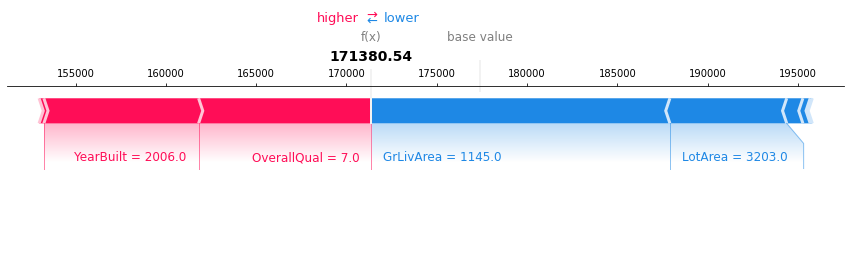

Number of test sample: 24


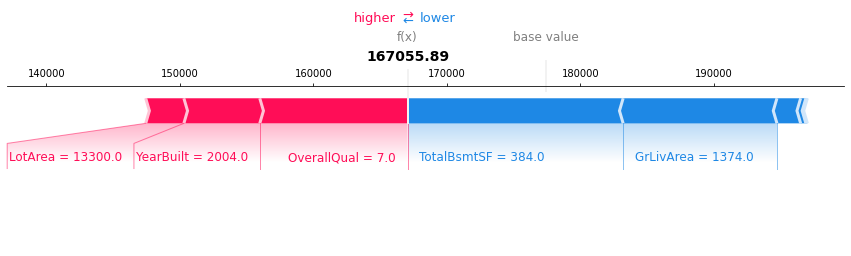

Number of test sample: 25


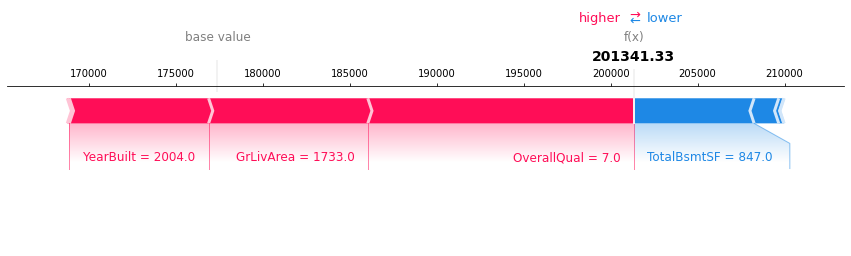

In [75]:
for sample_no in np.arange(23, 26):
    print(CLR + "Number of test sample:", RED + str(sample_no))
    shap.plots.force(
        forest_regressor_explainer.expected_value,
        housing_shap_values.values[sample_no],
        features=X_housing_test.iloc[[sample_no]].round(2),
        matplotlib=True,
        figsize=(15, 3),
    )


<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color: #FCFCFC;
    padding: 20px;
    border-radius: 4px;
    border: 1px solid #2F486B;
">
<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    border-bottom: 1px solid #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>Force Plot Explanation</b> 🕵
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    The three plots you see above are so-called <code>force</code> plots. <b>Force plot depicts feature contributions (Shapley values) as forces, where each feature can increase or decrease the prediction result</b>. In such a plot, the prediction starts from the baseline, which is the average prediction for the dataset, we passed as the background one. Red arrows push prediction to higher values, meanwhile blue arrows, on the other way around, towards lower values. <b>Remember that these plots above show an explanation for one specific observation.</b> Notice that in the first case, the prediction is smaller than the baseline. The main features that contribute to such a result are <code>YearBuilt</code>, <code>OverallQual</code>, <code>GrLivArea</code>, and <code>LotArea</code>. We can see that the general area of living pushes prediction towards smaller value. On the other hand, the house is rather still new and has good quality, which push the price to higher values.
</p>
</blockquote>

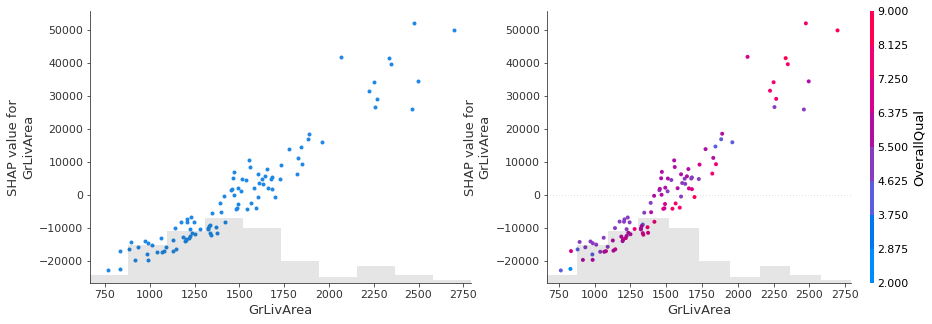

In [76]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
shap.plots.scatter(housing_shap_values[:, "GrLivArea"], ax=axes[0], show=False)
shap.plots.scatter(
    housing_shap_values[:, "GrLivArea"], color=housing_shap_values, ax=axes[1], show=False
)
plt.show()


<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color: #FCFCFC;
    padding: 20px;
    border-radius: 4px;
    border: 1px solid #2F486B;
">
<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    border-bottom: 1px solid #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>Scatter Plot Explanation</b> 🕵
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    This <code>scatter</code> plot is a simple dependence scatter plot. There we have all the single observations we passed to the explainer (observations which need to be explained, not the background dataset) and related to a chosen feature. <b>The x-axis represents the feature value, and the y-axis shows the Shapley value related to that specific sample.</b> Moreover, <code>shap</code> shows distribution of the feature at the bottom of the plot. And that's the plot on the left. The plot on the right needs a more profound explanation. As you can see, there is a vertical dispersion of dots. It means that sometimes the same value of <code>GrLivArea</code> may have a different impact on prediction depending on the observation. It suggests that there are non-linear interaction effects between <code>GrLivArea</code> and other features. That's the point. The second plot shows which feature is driving the strongest interaction with <code>GrLivArea</code>. In this case, it's <code>OverallQual</code>.
</p>
</blockquote>

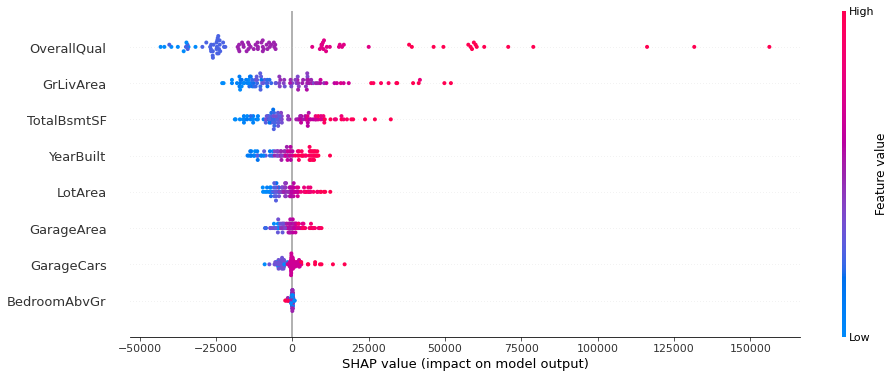

In [77]:
shap.plots.beeswarm(housing_shap_values, plot_size=(15, 6))


<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color: #FCFCFC;
    padding: 20px;
    border-radius: 4px;
    border: 1px solid #2F486B;
">
<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    border-bottom: 1px solid #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>Beeswarm Plot Explanation</b> 🕵
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    There we have the <code>beeswarm</code> plot. <b>Generally, this kind of plot shows the features' importance with their impact on the model.</b> Each instance we passed to the explainer is represented by a single dot. The position of that dot on the x-axis is specified by the Shapley value. As you can see, these dots resemble something like a distribution of Shapley values. The <code>beeswarm</code> plot accounts for an information summary of how the most important features influence the model output. Features ordering is reflected by the absolute mean Shapley value for each feature. In this case, the interpretation is simple. If the value of the feature grows, then the feature has a higher and positive contribution to the prediction. It's logical, for example, usually, when overall quality of the house is high, it means that it has a high positive contribution to the price.
</p>
</blockquote>

Number of test sample: 4


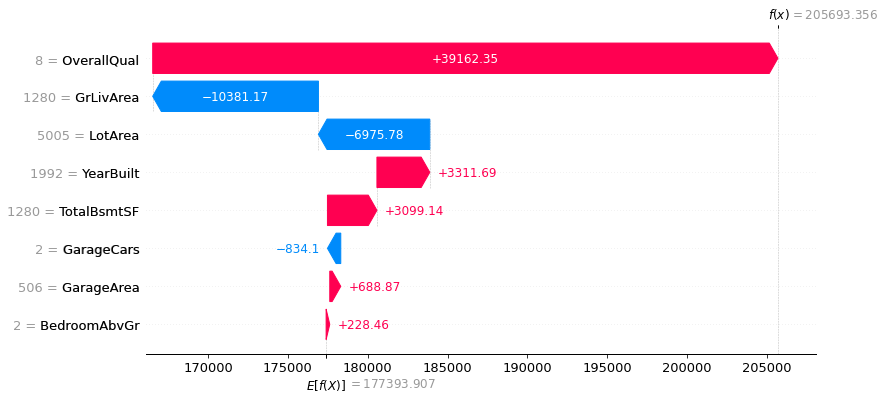

In [78]:
sample_no = 4
print(CLR + "Number of test sample:", RED + str(sample_no))
shap.plots.waterfall(housing_shap_values[sample_no], show=False)
plt.gcf().set_size_inches(12, 6)
plt.show()


<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color: #FCFCFC;
    padding: 20px;
    border-radius: 4px;
    border: 1px solid #2F486B;
">
<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    border-bottom: 1px solid #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>Waterfall Plot Explanation</b> 🕵
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    Another interesting type of plot - the <code>waterfall</code> plot. It concerns the specific observation and its prediction. <b>The waterfall starts from the baseline - $E[f(x)]$ (average prediction for the background dataset), and each bar tells us about the positive (red) or negative (blue) contribution that each feature impacts on the baseline.</b> In this case, the highest influence has <code>OverallQual</code> (good quality), which strongly pushes prediction into higher value and <code>GrLivArea</code> (rather small living area), which pushes it towards smaller values.
</p>
</blockquote>

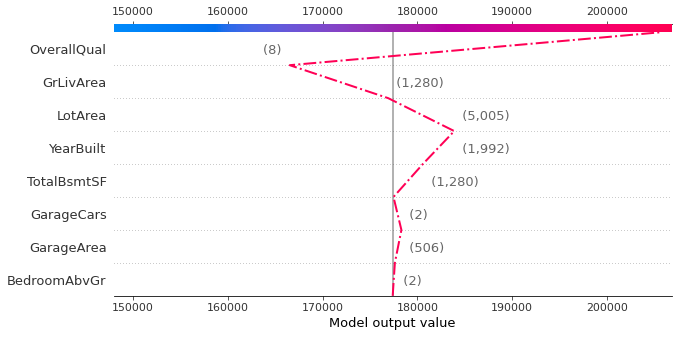

In [79]:
sample_no = 4
shap.plots.decision(
    forest_regressor_explainer.expected_value,
    housing_shap_values.values[sample_no],
    features=X_housing_test.iloc[[sample_no]],
    highlight=0,
    show=False,
)
plt.gcf().set_size_inches(10, 5)
plt.show()


<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color: #FCFCFC;
    padding: 20px;
    border-radius: 4px;
    border: 1px solid #2F486B;
">
<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    border-bottom: 1px solid #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>Decision Plot Explanation</b> 🕵
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    A <code>decision</code> plot is similar to the <code>waterfall</code> plot, but <b>it shows the decision process as a path</b>. The game starts from the baseline, which is the grey vertical line here, and each feature pushes prediction towards higher or lower values up to the final prediction. Moreover, <code>decision</code> plot allows to include more observations, we will see this effect later.
</p>
</blockquote>

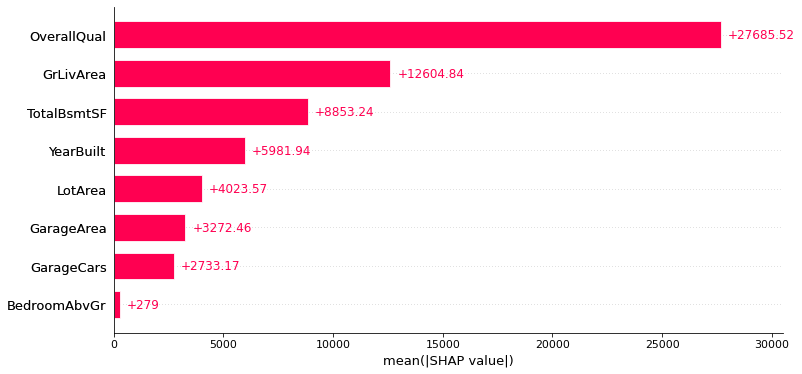

In [80]:
shap.plots.bar(housing_shap_values, show=False)
plt.gcf().set_size_inches(12, 6)
plt.show()


<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color: #FCFCFC;
    padding: 20px;
    border-radius: 4px;
    border: 1px solid #2F486B;
">
<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    border-bottom: 1px solid #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>Global Bar Plot Explanation</b> 🕵
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    The last type of plot I want to present is the global <code>bar</code> plot. <b>It shows global feature importances, where the feature importance is the mean absolute value of Shapley values for all samples passed to the explainer.</b> Generally, this kind of plot may account for a feature selection method. For example, in this case, the <code>BedroomAbvGr</code> feature has extremely small prediction power compared to the others.
</p>

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    border-bottom: 1px solid #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>Quick Summary</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    I hope you found <code>shap</code> useful. It's a rich library that offers much more types of plots and utilities than I presented here. Nevertheless, let's get to the classification problem, where <code>shap</code> works similarly as for the regression, but there we operate on probabilities. 
</p>

</blockquote>

# <p style="padding: 20px; font-family: 'JetBrains Mono'; font-weight: bold; font-size: 100%; color: #2F486B; letter-spacing: 2px; text-align: center; border-radius: 4px; border: 1px solid #2F486B; background-color: #FCFCFC">SHAP in Classification</p>

<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color: #FCFCFC;
    padding: 20px;
    border-radius: 4px;
    border: 1px solid #2F486B;
">
<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    border-bottom: 1px solid #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>Notes</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    In this section, we will handle the classification problem and see how <code>shap</code> explains the model's output. For the purpose of the classification problem, I will use the <b>Titanic</b> dataset. Since we know the general workflow, let's tackle this immediately.
</p>
</blockquote>

In [81]:
competition = "titanic"

if not ON_KAGGLE:
    download_competition_from_kaggle(competition)
    train_path = "data/train.csv"
    test_path = "data/test.csv"
else:
    train_path = f"/kaggle/input/{competition}/train.csv"
    test_path = f"/kaggle/input/{competition}/test.csv"

titanic_train = pd.read_csv(train_path, index_col="PassengerId")
titanic_test = pd.read_csv(test_path, index_col="PassengerId")

titanic_train.head().style.set_table_styles(DF_STYLE)


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.250000,nan,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.000000,1,0,PC 17599,71.283300,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.925000,nan,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.100000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.050000,nan,S


<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color: #FCFCFC;
    padding: 20px;
    border-radius: 4px;
    border: 1px solid #2F486B;
">
<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    border-bottom: 1px solid #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>Notes</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    Here we have ten different features, but similarly to earlier, we won't be using all of them. For example, <code>Cabin</code> has a lot of missing values, so we can reject this, also <code>Ticket</code> will not be important. Let's define small preprocessing.
</p>
</blockquote>

In [82]:
titanic_preprocess = make_column_transformer(
    (
        SimpleImputer(strategy="median"),
        make_column_selector(dtype_include="number"),  # type: ignore
    ),
    (
        make_pipeline(
            SimpleImputer(strategy="most_frequent"),
            OrdinalEncoder(),
        ),
        make_column_selector(dtype_include="object"),  # type: ignore
    ),
    verbose_feature_names_out=False,
).set_output(transform="pandas")

titanic_feature_names = [
    "Pclass",
    "Sex",
    "Age",
    "SibSp",
    "Parch",
    "Fare",
    "Embarked",
]

X_titanic_train = titanic_preprocess.fit_transform(titanic_train[titanic_feature_names])
y_titanic_train = titanic_train["Survived"]
X_titanic_test = titanic_preprocess.transform(titanic_test[titanic_feature_names])

X_titanic_train.head().style.set_table_styles(DF_STYLE)


,Pclass,Age,SibSp,Parch,Fare,Sex,Embarked
PassengerId,,,,,,,
1,3.000000,22.000000,1.000000,0.000000,7.250000,1.000000,2.000000
2,1.000000,38.000000,1.000000,0.000000,71.283300,0.000000,0.000000
3,3.000000,26.000000,0.000000,0.000000,7.925000,0.000000,2.000000
4,1.000000,35.000000,1.000000,0.000000,53.100000,0.000000,2.000000
5,3.000000,35.000000,0.000000,0.000000,8.050000,1.000000,2.000000


In [83]:
titanic_forest_classifier = RandomForestClassifier(
    random_state=42,
    min_samples_leaf=8,
).fit(X_titanic_train, y_titanic_train)

forest_classifier_explainer = explainers.Tree(
    titanic_forest_classifier,
    feature_perturbation="tree_path_dependent",
    feature_names=titanic_preprocess.get_feature_names_out(),  # type: ignore
)

titanic_shap_values = forest_classifier_explainer(X_titanic_test)


<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color: #FCFCFC;
    padding: 20px;
    border-radius: 4px;
    border: 1px solid #2F486B;
">
<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    border-bottom: 1px solid #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>General Remarks</b> 💡
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    Let's stay here for the moment. Similarly, as in the regression, we define a model, a classifier in this case. We train it and pass to the explainer. As we use the random forest, we take a tree-based explainer. However,  now for a little change, we set <code>tree_path_dependent</code> as <code>feature_perturbation</code>. It means that we don't need to provide a background dataset, and the explainer should infer background distribution from the model structure. Apart from that, the code is almost the same as in regression. Let's get to the visualisations.
</p>
</blockquote>

Number of test sample: 0


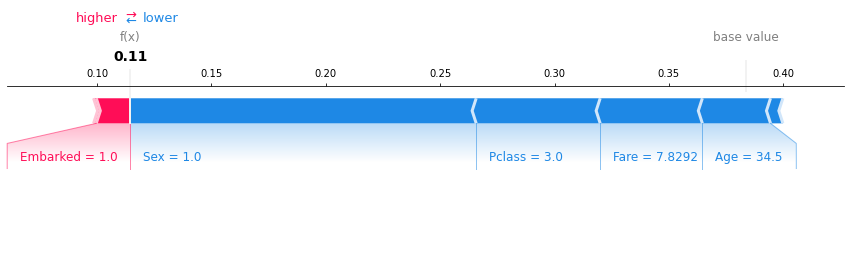

Number of test sample: 1


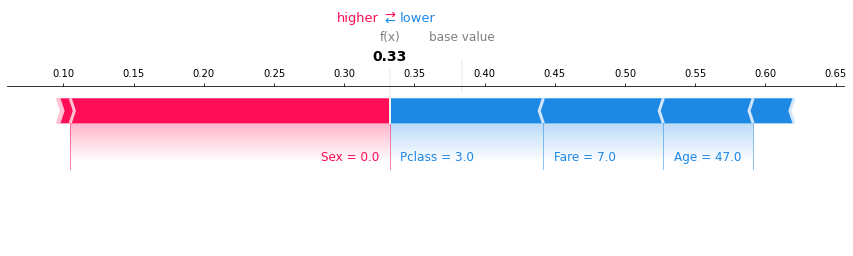

Number of test sample: 2


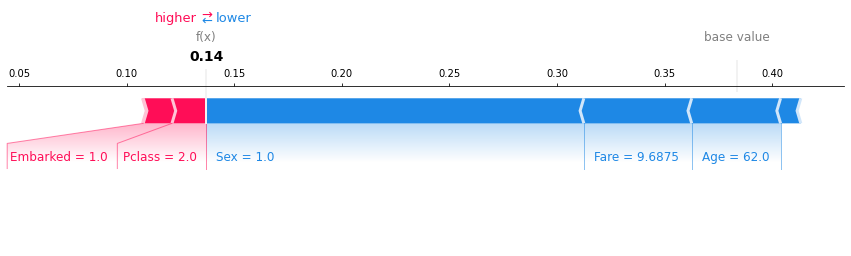

In [84]:
for sample_no in np.arange(0, 3):
    print(CLR + "Number of test sample:", RED + str(sample_no))
    shap.plots.force(
        forest_classifier_explainer.expected_value[1],  # Positive class probability.
        titanic_shap_values.values[sample_no, :, 1],  # Positive class probability.
        features=X_titanic_test.iloc[[sample_no]],
        matplotlib=True,
        figsize=(15, 3),
    )


<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color: #FCFCFC;
    padding: 20px;
    border-radius: 4px;
    border: 1px solid #2F486B;
">
<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    border-bottom: 1px solid #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>Force Plot Observations</b> 📔
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    Again, there, we have some <code>force</code> plots related to individual samples. The baseline probability that the passenger survived is equal to $0.38$. We are trying to explain why somebody has a higher chance and somebody lower. So, in the first case, we can see that being a man (<code>Sex=1</code>) strongly pushes the probability towards lower values. The fact that this passenger travelled within 3rd class for a small fee does not help either. In the second case, we are dealing with a woman (<code>Sex=0</code>). Being a woman on the Titanic board was a huge boost to the chance of survival. However, she travelled within 3rd class, which pushes probability to lower values.
</p>
</blockquote>

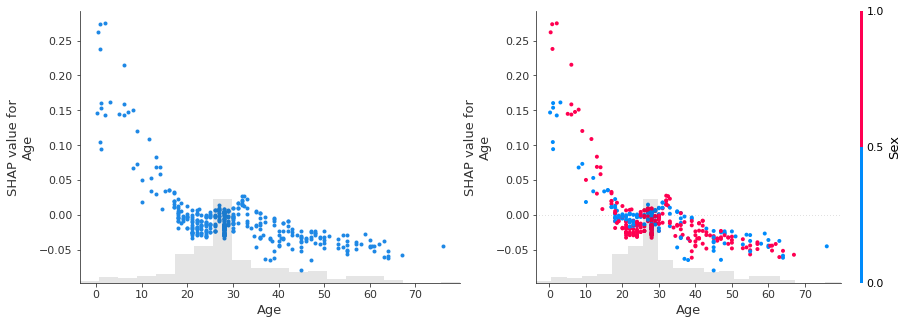

In [85]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
shap.plots.scatter(titanic_shap_values[:, "Age", 1], ax=axes[0], show=False)
shap.plots.scatter(
    titanic_shap_values[:, "Age", 1],
    color=titanic_shap_values[:, :, 1],
    ax=axes[1],
    show=False,
)
plt.show()


<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color: #FCFCFC;
    padding: 20px;
    border-radius: 4px;
    border: 1px solid #2F486B;
">
<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    border-bottom: 1px solid #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>Scatter Plot Observations</b> 📔
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    There we have the <code>scatter</code> plot of the <code>Age</code> feature. Again, there is a vertical dispersion of Shapley values related to the particular age, which means that somebody who has $20$ years old might have a higher chance of surviving than somebody who is $20$ years old too. There must be an interaction effect between <code>Age</code> and other features. It turns out that the strongest interaction with <code>Age</code> has <code>Sex</code>. Logical since women had a higher chance of surviving than men.
</p>
</blockquote>

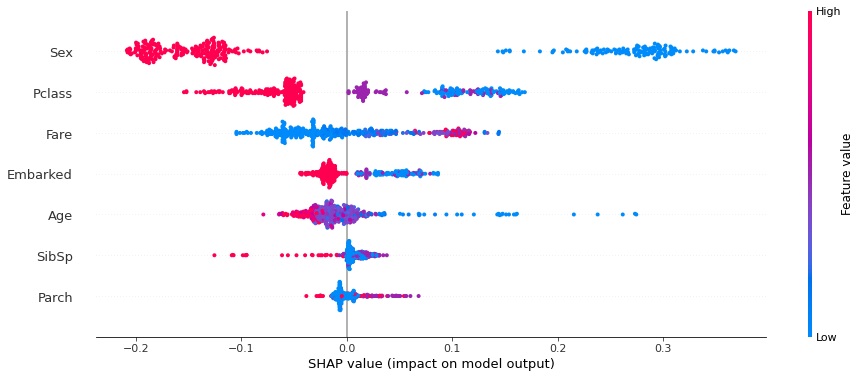

In [86]:
shap.plots.beeswarm(titanic_shap_values[:, :, 1], plot_size=(15, 6))


<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color: #FCFCFC;
    padding: 20px;
    border-radius: 4px;
    border: 1px solid #2F486B;
">
<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    border-bottom: 1px solid #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>Beeswarm Plot Observations</b> 📔
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    The <code>beeswarm</code> plot is kinda different than for House Prices dataset. There, higher values of features had a higher positive contribution to the prediction. Here, as you can see, we have a clear division between women and men. Being a man has a strong negative contribution to the probability of surviving. For women, the other way around. We can see something similar in the <code>Pclass</code> feature. The first class contributes positively to the probability of surviving. The second one has a small and still positive contribution. The third class has a strong negative contribution to the prediction.
</p>
</blockquote>

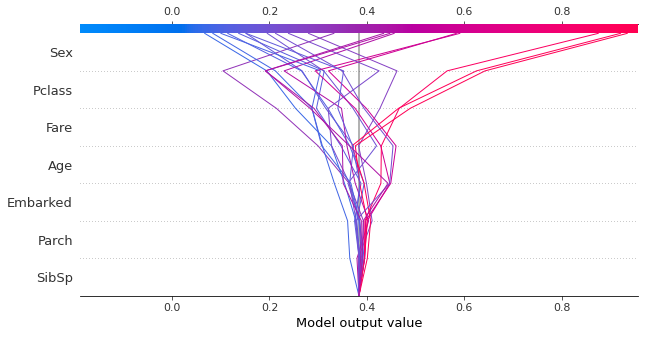

In [87]:
shap.plots.decision(
    forest_classifier_explainer.expected_value[1],
    titanic_shap_values.values[:20, :, 1],
    feature_names=forest_classifier_explainer.feature_names,
    show=False,
)
plt.gcf().set_size_inches(10, 5)
plt.show()


<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color: #FCFCFC;
    padding: 20px;
    border-radius: 4px;
    border: 1px solid #2F486B;
">
<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    border-bottom: 1px solid #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>Decision Plot Observations</b> 📔
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    The last plot is a <code>decision</code> plot for several samples. It's less readable than the individual one, but I just wanted to show you this.
</p>
</blockquote>

# <p style="padding: 20px; font-family: 'JetBrains Mono'; font-weight: bold; font-size: 100%; color: #2F486B; letter-spacing: 2px; text-align: center; border-radius: 4px; border: 1px solid #2F486B; background-color: #FCFCFC">Summary</p>

<blockquote style="
    margin-right: auto; 
    margin-left: auto; 
    background-color: #FCFCFC;
    padding: 20px;
    border-radius: 4px;
    border: 1px solid #2F486B;
">
<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    border-bottom: 1px solid #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>SHAP and Shapley values</b> 💡
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    SHAP is a method from cooperative game theory based on the Shapley values. It allows you to explain any machine learning model by considering the prediction process as a game, where certain features are players and the prediction is an outcome. SHAP tells you how to distribute features contribution fairly into the final result for a given sample.<br><br>
    Shapley value is an average marginal contribution of a feature value across all possible coalitions of features. The interpretation of Shapley value for sample $x$ and feature $j$ is that the value of feature $j$ contributed in different coalitions by $\hat{\phi}_j(x)$ to the prediction for this specific observation, in comparison to the average prediction. We can consider the Monte Carlo sampling method described earlier to calculate the approximate Shapley value.<br><br>
    The <code>shap</code> library is based on Shapley values (and their extensions) and designed to explain any machine learning model (from simple linear regression up to neural networks). It accounts for a rich library which offers much more than I described in this notebook. It allows you to explain the model's output with different plots and visualizations, helping you better understand your model and modelling.
</p>

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    border-bottom: 1px solid #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>References</b> 📔
</p>

<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
     margin-left: 15px;
    margin-right: 15px;
">
    <li><a href="https://arxiv.org/abs/1705.07874" style="color: #C94040"><b>A Unified Approach to Interpreting Model Predictions</b></a></li>
    <li><a href="https://christophm.github.io/interpretable-ml-book/shapley.html" style="color: #C94040"><b>Shapley Values</b></a></li>
    <li><a href="https://christophm.github.io/interpretable-ml-book/shap.html" style="color: #C94040"><b>SHAP (SHapley Additive exPlanations)</b></a></li>
    <li><a href="https://arxiv.org/abs/1910.13413" style="color: #C94040"><b>Feature relevance quantification in explainable AI: A causal problem</b></a></li>
    <li><a href="https://shap.readthedocs.io/en/latest/" style="color: #C94040"><b>SHAP documentation</b></a></li>
</ul>

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    border-bottom: 1px solid #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    <b>Other Notebooks</b> 📈
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #2F486B;
    margin-left: 15px;
    margin-right: 15px;
">
    That's all in this notebook. I hope you enjoyed that, and if you have any questions, please let me know in the comments section. Moreover, if you like it, I encourage you to get familiar with my other notebooks. Maybe you will find something useful there. Especially you can look at <a href="https://www.kaggle.com/code/mateuszk013/neural-machine-translation-with-attention" style="color: #C94040;"><b>Neural Machine Translation with Attention</b></a> and <a href="https://www.kaggle.com/code/mateuszk013/forecasting-weather-patterns-with-arima-rnn" style="color: #C94040;"><b>Forecasting Weather Patterns with ARIMA & RNN</b></a>.
</p>

</blockquote>